In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.utils import make_grid, save_image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
batch_size = 128
image_size = (64, 64)
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
latent_size = 16

In [4]:
transform_dataset = transforms.Compose([transforms.Resize(image_size),
                                        transforms.ToTensor(),
                                        transforms.Normalize(*stats)
                                        ])

In [5]:
train_dataset = torchvision.datasets.ImageFolder(root="/kaggle/input/best-artworks-of-all-time/resized",
                                                 transform=transform_dataset)

In [6]:
train_dl = DataLoader(train_dataset, batch_size, shuffle=True, pin_memory=True)

In [7]:
print(len(train_dataset))

8683


In [8]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [9]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
    plt.show()

In [10]:
def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

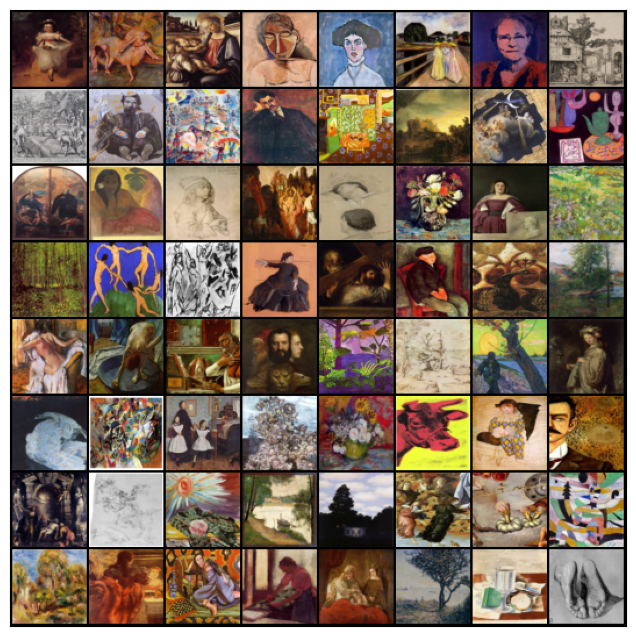

In [11]:
show_batch(train_dl)

In [12]:
atent_size = 16

discriminator = nn.Sequential(
    # in: 3 x 64 x 64
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16
    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8
    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4
    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out 512 x 1 x 1
    nn.Flatten(),
    nn.Sigmoid()
)

generator = nn.Sequential(
    # in: latent_size x 1 x 1
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4
    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8
    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16
    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32
    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)


In [13]:
discriminator = discriminator.to(device)
generator = generator.to(device)

In [14]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb.cuda())
print(fake_images.shape)

torch.Size([128, 3, 64, 64])


In [15]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()
    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [16]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [17]:
sample_dir = 'generated_me'
os.makedirs(sample_dir, exist_ok=True)

In [18]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(192, 108))
        ax.set_xticks([]);
        ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))
        print("SHOWN LAN")

In [19]:
fixed_latent = torch.randn(latent_size, latent_size, 1, 1, device=device)
print(fixed_latent.shape)
save_samples(0, fixed_latent)

torch.Size([16, 16, 1, 1])
Saving generated-images-0000.png
SHOWN LAN


In [20]:
def fit_model(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images.to(device), opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch + 1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch + start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [21]:
lr = 0.0002
epochs = 300

In [ ]:
history = fit_model(epochs, lr)

  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [1/300], loss_g: 2.7809, loss_d: 0.4095, real_score: 0.7493, fake_score: 0.0971
Saving generated-images-0001.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [2/300], loss_g: 2.8945, loss_d: 0.7949, real_score: 0.8237, fake_score: 0.4169
Saving generated-images-0002.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [3/300], loss_g: 3.0319, loss_d: 1.2019, real_score: 0.3906, fake_score: 0.0173
Saving generated-images-0003.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [4/300], loss_g: 3.1752, loss_d: 0.1790, real_score: 0.8717, fake_score: 0.0362
Saving generated-images-0004.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [5/300], loss_g: 3.8881, loss_d: 1.0617, real_score: 0.7426, fake_score: 0.4683
Saving generated-images-0005.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [6/300], loss_g: 2.5320, loss_d: 0.7450, real_score: 0.7542, fake_score: 0.3191
Saving generated-images-0006.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [7/300], loss_g: 2.7853, loss_d: 0.6263, real_score: 0.6334, fake_score: 0.1008
Saving generated-images-0007.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [8/300], loss_g: 2.5793, loss_d: 0.4210, real_score: 0.8496, fake_score: 0.1994
Saving generated-images-0008.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [9/300], loss_g: 3.9357, loss_d: 0.6606, real_score: 0.8166, fake_score: 0.3349
Saving generated-images-0009.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [10/300], loss_g: 2.6457, loss_d: 0.5393, real_score: 0.6924, fake_score: 0.1134
Saving generated-images-0010.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [11/300], loss_g: 2.2467, loss_d: 0.4478, real_score: 0.7811, fake_score: 0.1619
Saving generated-images-0011.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [12/300], loss_g: 3.9305, loss_d: 0.2881, real_score: 0.8793, fake_score: 0.1362
Saving generated-images-0012.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [13/300], loss_g: 1.9735, loss_d: 0.6872, real_score: 0.6087, fake_score: 0.0907
Saving generated-images-0013.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [14/300], loss_g: 2.3352, loss_d: 0.9332, real_score: 0.5489, fake_score: 0.1919
Saving generated-images-0014.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [15/300], loss_g: 4.7470, loss_d: 0.6220, real_score: 0.9157, fake_score: 0.3811
Saving generated-images-0015.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [16/300], loss_g: 3.8087, loss_d: 0.6377, real_score: 0.8478, fake_score: 0.3340
Saving generated-images-0016.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [17/300], loss_g: 2.0323, loss_d: 0.6484, real_score: 0.6499, fake_score: 0.1534
Saving generated-images-0017.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [18/300], loss_g: 3.2775, loss_d: 0.5908, real_score: 0.6671, fake_score: 0.1220
Saving generated-images-0018.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [19/300], loss_g: 2.7433, loss_d: 0.7017, real_score: 0.5976, fake_score: 0.1109
Saving generated-images-0019.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [20/300], loss_g: 1.6820, loss_d: 1.0943, real_score: 0.4313, fake_score: 0.0074
Saving generated-images-0020.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [21/300], loss_g: 2.4630, loss_d: 1.1864, real_score: 0.3815, fake_score: 0.0323
Saving generated-images-0021.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [22/300], loss_g: 2.4791, loss_d: 0.7096, real_score: 0.5777, fake_score: 0.0499
Saving generated-images-0022.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [23/300], loss_g: 2.6435, loss_d: 0.6192, real_score: 0.7547, fake_score: 0.2426
Saving generated-images-0023.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [24/300], loss_g: 6.6933, loss_d: 1.1217, real_score: 0.9398, fake_score: 0.6143
Saving generated-images-0024.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [25/300], loss_g: 3.3144, loss_d: 0.2800, real_score: 0.9531, fake_score: 0.1924
Saving generated-images-0025.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [26/300], loss_g: 3.9931, loss_d: 0.5687, real_score: 0.9257, fake_score: 0.3554
Saving generated-images-0026.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [27/300], loss_g: 4.4211, loss_d: 0.7121, real_score: 0.8682, fake_score: 0.4047
Saving generated-images-0027.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [28/300], loss_g: 3.9177, loss_d: 0.3550, real_score: 0.8228, fake_score: 0.1207
Saving generated-images-0028.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [29/300], loss_g: 1.5706, loss_d: 2.0283, real_score: 0.1934, fake_score: 0.0007
Saving generated-images-0029.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [30/300], loss_g: 7.0591, loss_d: 0.9701, real_score: 0.9692, fake_score: 0.5413
Saving generated-images-0030.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [31/300], loss_g: 5.8933, loss_d: 0.5182, real_score: 0.9267, fake_score: 0.3192
Saving generated-images-0031.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [32/300], loss_g: 3.2577, loss_d: 0.4093, real_score: 0.8958, fake_score: 0.2267
Saving generated-images-0032.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [33/300], loss_g: 2.9621, loss_d: 0.6022, real_score: 0.6170, fake_score: 0.0256
Saving generated-images-0033.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [34/300], loss_g: 2.8052, loss_d: 0.3158, real_score: 0.8463, fake_score: 0.1239
Saving generated-images-0034.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [35/300], loss_g: 6.8012, loss_d: 1.0864, real_score: 0.9777, fake_score: 0.5762
Saving generated-images-0035.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [36/300], loss_g: 4.0828, loss_d: 0.7478, real_score: 0.8484, fake_score: 0.3886
Saving generated-images-0036.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [37/300], loss_g: 3.3746, loss_d: 0.2778, real_score: 0.8171, fake_score: 0.0493
Saving generated-images-0037.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [38/300], loss_g: 3.1692, loss_d: 0.5057, real_score: 0.7394, fake_score: 0.1388
Saving generated-images-0038.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [39/300], loss_g: 4.2832, loss_d: 0.3154, real_score: 0.8709, fake_score: 0.1388
Saving generated-images-0039.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [40/300], loss_g: 4.0290, loss_d: 0.5251, real_score: 0.9485, fake_score: 0.3392
Saving generated-images-0040.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [41/300], loss_g: 6.4188, loss_d: 0.9222, real_score: 0.9732, fake_score: 0.5117
Saving generated-images-0041.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [42/300], loss_g: 2.6912, loss_d: 0.5693, real_score: 0.6352, fake_score: 0.0259
Saving generated-images-0042.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [43/300], loss_g: 6.4871, loss_d: 0.6502, real_score: 0.9806, fake_score: 0.4243
Saving generated-images-0043.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [44/300], loss_g: 2.9583, loss_d: 0.4300, real_score: 0.7273, fake_score: 0.0639
Saving generated-images-0044.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [45/300], loss_g: 6.6124, loss_d: 1.1174, real_score: 0.9606, fake_score: 0.5887
Saving generated-images-0045.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [46/300], loss_g: 2.4996, loss_d: 0.6597, real_score: 0.5832, fake_score: 0.0313
Saving generated-images-0046.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [47/300], loss_g: 2.8681, loss_d: 0.4181, real_score: 0.7984, fake_score: 0.1447
Saving generated-images-0047.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [48/300], loss_g: 2.5397, loss_d: 0.2936, real_score: 0.8011, fake_score: 0.0497
Saving generated-images-0048.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [49/300], loss_g: 5.3626, loss_d: 0.6277, real_score: 0.9428, fake_score: 0.3945
Saving generated-images-0049.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [50/300], loss_g: 2.7596, loss_d: 0.4005, real_score: 0.8357, fake_score: 0.1645
Saving generated-images-0050.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [51/300], loss_g: 4.4445, loss_d: 0.2388, real_score: 0.8559, fake_score: 0.0653
Saving generated-images-0051.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [52/300], loss_g: 7.6763, loss_d: 1.2331, real_score: 0.9401, fake_score: 0.5958
Saving generated-images-0052.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [53/300], loss_g: 4.9142, loss_d: 0.5335, real_score: 0.9393, fake_score: 0.3352
Saving generated-images-0053.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [54/300], loss_g: 2.5920, loss_d: 0.4601, real_score: 0.7538, fake_score: 0.1216
Saving generated-images-0054.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [55/300], loss_g: 3.5121, loss_d: 0.8316, real_score: 0.7741, fake_score: 0.3843
Saving generated-images-0055.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [56/300], loss_g: 4.1607, loss_d: 1.0028, real_score: 0.4335, fake_score: 0.0096
Saving generated-images-0056.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [57/300], loss_g: 5.7620, loss_d: 0.5263, real_score: 0.9684, fake_score: 0.3527
Saving generated-images-0057.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [58/300], loss_g: 3.2844, loss_d: 0.3823, real_score: 0.7936, fake_score: 0.1122
Saving generated-images-0058.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [59/300], loss_g: 2.4911, loss_d: 0.7586, real_score: 0.5459, fake_score: 0.0402
Saving generated-images-0059.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [60/300], loss_g: 4.1962, loss_d: 0.4190, real_score: 0.9583, fake_score: 0.2782
Saving generated-images-0060.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [61/300], loss_g: 1.9781, loss_d: 1.3500, real_score: 0.3562, fake_score: 0.0111
Saving generated-images-0061.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [62/300], loss_g: 3.7074, loss_d: 0.3842, real_score: 0.9589, fake_score: 0.2666
Saving generated-images-0062.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [63/300], loss_g: 3.2872, loss_d: 0.5301, real_score: 0.6494, fake_score: 0.0214
Saving generated-images-0063.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [64/300], loss_g: 3.6006, loss_d: 0.5868, real_score: 0.6030, fake_score: 0.0120
Saving generated-images-0064.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [65/300], loss_g: 5.8415, loss_d: 1.2405, real_score: 0.9257, fake_score: 0.6251
Saving generated-images-0065.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [66/300], loss_g: 3.7108, loss_d: 0.8389, real_score: 0.8447, fake_score: 0.2973
Saving generated-images-0066.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [67/300], loss_g: 2.7597, loss_d: 0.1712, real_score: 0.9368, fake_score: 0.0938
Saving generated-images-0067.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [68/300], loss_g: 2.0496, loss_d: 0.5072, real_score: 0.6835, fake_score: 0.0369
Saving generated-images-0068.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [69/300], loss_g: 0.9795, loss_d: 1.1196, real_score: 0.4541, fake_score: 0.0811
Saving generated-images-0069.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [70/300], loss_g: 2.2665, loss_d: 0.4233, real_score: 0.7647, fake_score: 0.1057
Saving generated-images-0070.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [71/300], loss_g: 4.0767, loss_d: 0.2523, real_score: 0.9155, fake_score: 0.1384
Saving generated-images-0071.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [72/300], loss_g: 3.7916, loss_d: 0.3388, real_score: 0.7665, fake_score: 0.0292
Saving generated-images-0072.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [73/300], loss_g: 4.2911, loss_d: 0.3904, real_score: 0.9784, fake_score: 0.2629
Saving generated-images-0073.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [74/300], loss_g: 2.3108, loss_d: 0.4180, real_score: 0.7099, fake_score: 0.0348
Saving generated-images-0074.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [75/300], loss_g: 4.1742, loss_d: 0.2768, real_score: 0.8471, fake_score: 0.0835
Saving generated-images-0075.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [76/300], loss_g: 2.9052, loss_d: 0.8191, real_score: 0.5175, fake_score: 0.0081
Saving generated-images-0076.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [77/300], loss_g: 4.7220, loss_d: 0.4073, real_score: 0.9466, fake_score: 0.2530
Saving generated-images-0077.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [78/300], loss_g: 4.8381, loss_d: 0.1178, real_score: 0.9298, fake_score: 0.0383
Saving generated-images-0078.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [79/300], loss_g: 3.4700, loss_d: 0.1270, real_score: 0.9397, fake_score: 0.0582
Saving generated-images-0079.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [80/300], loss_g: 3.4813, loss_d: 0.2433, real_score: 0.9067, fake_score: 0.1185
Saving generated-images-0080.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [81/300], loss_g: 1.2750, loss_d: 0.5297, real_score: 0.6525, fake_score: 0.0375
Saving generated-images-0081.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [82/300], loss_g: 5.3709, loss_d: 0.3847, real_score: 0.9491, fake_score: 0.2559
Saving generated-images-0082.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [83/300], loss_g: 2.9916, loss_d: 0.5024, real_score: 0.8894, fake_score: 0.2654
Saving generated-images-0083.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [84/300], loss_g: 2.5269, loss_d: 0.4890, real_score: 0.6898, fake_score: 0.0429
Saving generated-images-0084.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [85/300], loss_g: 2.2813, loss_d: 1.0251, real_score: 0.4639, fake_score: 0.0131
Saving generated-images-0085.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [86/300], loss_g: 1.9942, loss_d: 0.3491, real_score: 0.8057, fake_score: 0.0910
Saving generated-images-0086.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [87/300], loss_g: 4.8422, loss_d: 0.0960, real_score: 0.9333, fake_score: 0.0239
Saving generated-images-0087.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [88/300], loss_g: 4.0940, loss_d: 0.4658, real_score: 0.9126, fake_score: 0.2626
Saving generated-images-0088.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [89/300], loss_g: 3.5867, loss_d: 0.2260, real_score: 0.9043, fake_score: 0.1070
Saving generated-images-0089.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [90/300], loss_g: 0.8615, loss_d: 0.6956, real_score: 0.5841, fake_score: 0.0591
Saving generated-images-0090.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [91/300], loss_g: 3.1216, loss_d: 0.1707, real_score: 0.9078, fake_score: 0.0610
Saving generated-images-0091.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [92/300], loss_g: 4.4998, loss_d: 0.3583, real_score: 0.9915, fake_score: 0.2628
Saving generated-images-0092.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [93/300], loss_g: 4.6949, loss_d: 0.1527, real_score: 0.9564, fake_score: 0.0982
Saving generated-images-0093.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [94/300], loss_g: 0.8553, loss_d: 1.5848, real_score: 0.3244, fake_score: 0.0805
Saving generated-images-0094.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [95/300], loss_g: 3.0363, loss_d: 0.2479, real_score: 0.9098, fake_score: 0.1252
Saving generated-images-0095.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [96/300], loss_g: 3.0400, loss_d: 0.2020, real_score: 0.9043, fake_score: 0.0867
Saving generated-images-0096.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [97/300], loss_g: 2.7319, loss_d: 0.4714, real_score: 0.7276, fake_score: 0.0952
Saving generated-images-0097.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [98/300], loss_g: 3.5861, loss_d: 0.3139, real_score: 0.9602, fake_score: 0.2176
Saving generated-images-0098.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [99/300], loss_g: 5.1286, loss_d: 0.3741, real_score: 0.9951, fake_score: 0.2786
Saving generated-images-0099.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [100/300], loss_g: 3.1062, loss_d: 0.4556, real_score: 0.6964, fake_score: 0.0348
Saving generated-images-0100.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [101/300], loss_g: 2.5423, loss_d: 0.2032, real_score: 0.8742, fake_score: 0.0520
Saving generated-images-0101.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [102/300], loss_g: 4.8503, loss_d: 0.1588, real_score: 0.9906, fake_score: 0.1279
Saving generated-images-0102.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [103/300], loss_g: 1.9985, loss_d: 0.5766, real_score: 0.6448, fake_score: 0.0107
Saving generated-images-0103.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [104/300], loss_g: 3.6381, loss_d: 0.3166, real_score: 0.8687, fake_score: 0.1435
Saving generated-images-0104.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [105/300], loss_g: 1.2000, loss_d: 0.6981, real_score: 0.5731, fake_score: 0.0281
Saving generated-images-0105.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [106/300], loss_g: 2.1121, loss_d: 0.4195, real_score: 0.7289, fake_score: 0.0509
Saving generated-images-0106.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [107/300], loss_g: 6.5646, loss_d: 0.0841, real_score: 0.9323, fake_score: 0.0078
Saving generated-images-0107.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [108/300], loss_g: 4.0623, loss_d: 0.1463, real_score: 0.8972, fake_score: 0.0291
Saving generated-images-0108.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [109/300], loss_g: 4.8726, loss_d: 0.4949, real_score: 0.9785, fake_score: 0.3236
Saving generated-images-0109.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [110/300], loss_g: 4.7937, loss_d: 0.0948, real_score: 0.9283, fake_score: 0.0168
Saving generated-images-0110.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [111/300], loss_g: 3.1827, loss_d: 0.1462, real_score: 0.9203, fake_score: 0.0550
Saving generated-images-0111.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [112/300], loss_g: 4.3795, loss_d: 0.1022, real_score: 0.9832, fake_score: 0.0774
Saving generated-images-0112.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [113/300], loss_g: 4.2839, loss_d: 0.1886, real_score: 0.8975, fake_score: 0.0607
Saving generated-images-0113.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [114/300], loss_g: 3.9773, loss_d: 0.1616, real_score: 0.9068, fake_score: 0.0535
Saving generated-images-0114.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [115/300], loss_g: 4.3490, loss_d: 0.3151, real_score: 0.9016, fake_score: 0.1555
Saving generated-images-0115.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [116/300], loss_g: 2.0644, loss_d: 0.1253, real_score: 0.9659, fake_score: 0.0826
Saving generated-images-0116.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [117/300], loss_g: 2.6660, loss_d: 0.2110, real_score: 0.8845, fake_score: 0.0758
Saving generated-images-0117.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [118/300], loss_g: 5.3160, loss_d: 0.0401, real_score: 0.9820, fake_score: 0.0211
Saving generated-images-0118.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [119/300], loss_g: 3.7203, loss_d: 0.1498, real_score: 0.8832, fake_score: 0.0184
Saving generated-images-0119.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [120/300], loss_g: 4.5381, loss_d: 0.3161, real_score: 0.7904, fake_score: 0.0420
Saving generated-images-0120.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [121/300], loss_g: 6.3950, loss_d: 0.0868, real_score: 0.9604, fake_score: 0.0434
Saving generated-images-0121.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [122/300], loss_g: 5.1234, loss_d: 0.0731, real_score: 0.9500, fake_score: 0.0198
Saving generated-images-0122.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [123/300], loss_g: 3.6405, loss_d: 0.1152, real_score: 0.9636, fake_score: 0.0707
Saving generated-images-0123.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [124/300], loss_g: 4.2062, loss_d: 0.4172, real_score: 0.9636, fake_score: 0.2775
Saving generated-images-0124.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [125/300], loss_g: 4.7446, loss_d: 0.2023, real_score: 0.9250, fake_score: 0.0895
Saving generated-images-0125.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [126/300], loss_g: 4.1680, loss_d: 0.1514, real_score: 0.9519, fake_score: 0.0913
Saving generated-images-0126.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [127/300], loss_g: 4.3402, loss_d: 0.1347, real_score: 0.9274, fake_score: 0.0508
Saving generated-images-0127.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [128/300], loss_g: 5.4546, loss_d: 0.2131, real_score: 0.9072, fake_score: 0.0939
Saving generated-images-0128.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [129/300], loss_g: 5.1606, loss_d: 0.0956, real_score: 0.9489, fake_score: 0.0367
Saving generated-images-0129.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [130/300], loss_g: 3.7738, loss_d: 0.2030, real_score: 0.9594, fake_score: 0.1303
Saving generated-images-0130.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [131/300], loss_g: 5.8318, loss_d: 0.1691, real_score: 0.8780, fake_score: 0.0213
Saving generated-images-0131.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [132/300], loss_g: 2.4488, loss_d: 0.3054, real_score: 0.8150, fake_score: 0.0743
Saving generated-images-0132.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [133/300], loss_g: 3.8492, loss_d: 0.1711, real_score: 0.9240, fake_score: 0.0750
Saving generated-images-0133.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [134/300], loss_g: 1.8205, loss_d: 2.4967, real_score: 0.2330, fake_score: 0.0179
Saving generated-images-0134.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [135/300], loss_g: 2.8704, loss_d: 0.3797, real_score: 0.7951, fake_score: 0.0920
Saving generated-images-0135.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [136/300], loss_g: 4.6708, loss_d: 0.3243, real_score: 0.7794, fake_score: 0.0360
Saving generated-images-0136.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [137/300], loss_g: 4.6121, loss_d: 0.0987, real_score: 0.9815, fake_score: 0.0717
Saving generated-images-0137.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [138/300], loss_g: 4.0923, loss_d: 0.0645, real_score: 0.9757, fake_score: 0.0381
Saving generated-images-0138.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [139/300], loss_g: 3.9802, loss_d: 0.3246, real_score: 0.7668, fake_score: 0.0233
Saving generated-images-0139.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [140/300], loss_g: 4.8402, loss_d: 0.0509, real_score: 0.9826, fake_score: 0.0315
Saving generated-images-0140.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [141/300], loss_g: 3.6103, loss_d: 0.1877, real_score: 0.8474, fake_score: 0.0092
Saving generated-images-0141.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [142/300], loss_g: 4.4898, loss_d: 0.1136, real_score: 0.9683, fake_score: 0.0705
Saving generated-images-0142.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [143/300], loss_g: 6.5404, loss_d: 0.0378, real_score: 0.9921, fake_score: 0.0288
Saving generated-images-0143.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [144/300], loss_g: 2.9066, loss_d: 0.2164, real_score: 0.8799, fake_score: 0.0630
Saving generated-images-0144.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [145/300], loss_g: 3.8437, loss_d: 0.0958, real_score: 0.9415, fake_score: 0.0309
Saving generated-images-0145.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [146/300], loss_g: 3.6608, loss_d: 0.3318, real_score: 0.8001, fake_score: 0.0617
Saving generated-images-0146.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [147/300], loss_g: 3.7770, loss_d: 0.1754, real_score: 0.9049, fake_score: 0.0630
Saving generated-images-0147.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [148/300], loss_g: 4.2008, loss_d: 0.1361, real_score: 0.9137, fake_score: 0.0372
Saving generated-images-0148.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [149/300], loss_g: 2.9015, loss_d: 0.1838, real_score: 0.8633, fake_score: 0.0268
Saving generated-images-0149.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [150/300], loss_g: 2.9781, loss_d: 0.2390, real_score: 0.8160, fake_score: 0.0152
Saving generated-images-0150.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [151/300], loss_g: 5.4325, loss_d: 0.4174, real_score: 0.8038, fake_score: 0.0426
Saving generated-images-0151.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [152/300], loss_g: 4.3078, loss_d: 0.1227, real_score: 0.9296, fake_score: 0.0424
Saving generated-images-0152.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [153/300], loss_g: 4.1687, loss_d: 0.1744, real_score: 0.9378, fake_score: 0.0941
Saving generated-images-0153.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [154/300], loss_g: 3.6372, loss_d: 0.0868, real_score: 0.9521, fake_score: 0.0348
Saving generated-images-0154.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [155/300], loss_g: 4.6203, loss_d: 0.1583, real_score: 0.9678, fake_score: 0.1050
Saving generated-images-0155.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [156/300], loss_g: 2.7655, loss_d: 0.1466, real_score: 0.9186, fake_score: 0.0544
Saving generated-images-0156.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [157/300], loss_g: 4.0497, loss_d: 0.0881, real_score: 0.9786, fake_score: 0.0608
Saving generated-images-0157.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [158/300], loss_g: 4.9933, loss_d: 0.0588, real_score: 0.9798, fake_score: 0.0360
Saving generated-images-0158.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [159/300], loss_g: 5.4060, loss_d: 0.3605, real_score: 0.9884, fake_score: 0.2485
Saving generated-images-0159.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [160/300], loss_g: 3.2457, loss_d: 0.2230, real_score: 0.8367, fake_score: 0.0241
Saving generated-images-0160.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [161/300], loss_g: 5.0395, loss_d: 0.0550, real_score: 0.9586, fake_score: 0.0113
Saving generated-images-0161.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [162/300], loss_g: 4.9416, loss_d: 0.0662, real_score: 0.9743, fake_score: 0.0374
Saving generated-images-0162.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [163/300], loss_g: 4.7144, loss_d: 0.0739, real_score: 0.9643, fake_score: 0.0198
Saving generated-images-0163.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [164/300], loss_g: 5.5955, loss_d: 0.1122, real_score: 0.9860, fake_score: 0.0874
Saving generated-images-0164.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [165/300], loss_g: 2.3005, loss_d: 0.7132, real_score: 0.5606, fake_score: 0.0011
Saving generated-images-0165.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [166/300], loss_g: 3.9991, loss_d: 0.0783, real_score: 0.9562, fake_score: 0.0294
Saving generated-images-0166.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [167/300], loss_g: 5.4046, loss_d: 0.1604, real_score: 0.9859, fake_score: 0.1240
Saving generated-images-0167.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [168/300], loss_g: 6.6519, loss_d: 0.6706, real_score: 0.9590, fake_score: 0.3813
Saving generated-images-0168.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [169/300], loss_g: 3.8031, loss_d: 0.1444, real_score: 0.9748, fake_score: 0.1055
Saving generated-images-0169.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [170/300], loss_g: 3.1754, loss_d: 0.4762, real_score: 0.6830, fake_score: 0.0075
Saving generated-images-0170.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [171/300], loss_g: 4.9823, loss_d: 0.1181, real_score: 0.9859, fake_score: 0.0913
Saving generated-images-0171.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [172/300], loss_g: 5.6311, loss_d: 0.0906, real_score: 0.9801, fake_score: 0.0650
Saving generated-images-0172.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [173/300], loss_g: 3.2918, loss_d: 0.0885, real_score: 0.9897, fake_score: 0.0700
Saving generated-images-0173.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [174/300], loss_g: 5.7637, loss_d: 0.0512, real_score: 0.9606, fake_score: 0.0098
Saving generated-images-0174.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [175/300], loss_g: 3.8302, loss_d: 0.0934, real_score: 0.9456, fake_score: 0.0340
Saving generated-images-0175.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [176/300], loss_g: 3.6968, loss_d: 0.0648, real_score: 0.9825, fake_score: 0.0442
Saving generated-images-0176.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [177/300], loss_g: 4.5122, loss_d: 0.2252, real_score: 0.8543, fake_score: 0.0427
Saving generated-images-0177.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [178/300], loss_g: 4.2255, loss_d: 0.0697, real_score: 0.9610, fake_score: 0.0281
Saving generated-images-0178.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [179/300], loss_g: 2.6065, loss_d: 0.2617, real_score: 0.8101, fake_score: 0.0168
Saving generated-images-0179.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [180/300], loss_g: 3.9452, loss_d: 0.0890, real_score: 0.9473, fake_score: 0.0311
Saving generated-images-0180.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [181/300], loss_g: 5.0056, loss_d: 0.0302, real_score: 0.9824, fake_score: 0.0120
Saving generated-images-0181.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [182/300], loss_g: 5.5938, loss_d: 0.0309, real_score: 0.9843, fake_score: 0.0146
Saving generated-images-0182.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [183/300], loss_g: 3.6213, loss_d: 0.1382, real_score: 0.8949, fake_score: 0.0191
Saving generated-images-0183.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [184/300], loss_g: 4.4782, loss_d: 0.6623, real_score: 0.8342, fake_score: 0.2626
Saving generated-images-0184.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [185/300], loss_g: 5.1686, loss_d: 0.0442, real_score: 0.9883, fake_score: 0.0296
Saving generated-images-0185.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [186/300], loss_g: 4.1276, loss_d: 0.1436, real_score: 0.8912, fake_score: 0.0162
Saving generated-images-0186.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [187/300], loss_g: 4.0236, loss_d: 0.1250, real_score: 0.9203, fake_score: 0.0373
Saving generated-images-0187.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [188/300], loss_g: 4.8056, loss_d: 0.0373, real_score: 0.9978, fake_score: 0.0337
Saving generated-images-0188.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [189/300], loss_g: 6.0414, loss_d: 0.0575, real_score: 0.9535, fake_score: 0.0071
Saving generated-images-0189.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [190/300], loss_g: 3.8045, loss_d: 0.1063, real_score: 0.9201, fake_score: 0.0180
Saving generated-images-0190.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [191/300], loss_g: 6.3276, loss_d: 0.8559, real_score: 0.6517, fake_score: 0.0488
Saving generated-images-0191.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [192/300], loss_g: 6.3700, loss_d: 0.1868, real_score: 0.9901, fake_score: 0.1361
Saving generated-images-0192.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [193/300], loss_g: 4.4081, loss_d: 0.1311, real_score: 0.9173, fake_score: 0.0287
Saving generated-images-0193.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [194/300], loss_g: 3.7950, loss_d: 0.1081, real_score: 0.9522, fake_score: 0.0528
Saving generated-images-0194.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [195/300], loss_g: 4.7855, loss_d: 0.0724, real_score: 0.9548, fake_score: 0.0235
Saving generated-images-0195.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [196/300], loss_g: 4.1035, loss_d: 0.0638, real_score: 0.9500, fake_score: 0.0104
Saving generated-images-0196.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [197/300], loss_g: 4.5384, loss_d: 0.2204, real_score: 0.8267, fake_score: 0.0045
Saving generated-images-0197.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [198/300], loss_g: 4.3140, loss_d: 0.0677, real_score: 0.9566, fake_score: 0.0137
Saving generated-images-0198.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [199/300], loss_g: 2.1377, loss_d: 0.2924, real_score: 0.7741, fake_score: 0.0047
Saving generated-images-0199.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [200/300], loss_g: 1.0155, loss_d: 1.8828, real_score: 0.4358, fake_score: 0.1607
Saving generated-images-0200.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [201/300], loss_g: 6.1546, loss_d: 0.1391, real_score: 0.9538, fake_score: 0.0748
Saving generated-images-0201.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [202/300], loss_g: 1.1191, loss_d: 0.6965, real_score: 0.5985, fake_score: 0.0268
Saving generated-images-0202.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [203/300], loss_g: 6.3550, loss_d: 0.0494, real_score: 0.9822, fake_score: 0.0276
Saving generated-images-0203.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [204/300], loss_g: 6.2456, loss_d: 0.0411, real_score: 0.9759, fake_score: 0.0158
Saving generated-images-0204.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [205/300], loss_g: 4.9186, loss_d: 0.0571, real_score: 0.9573, fake_score: 0.0121
Saving generated-images-0205.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [206/300], loss_g: 4.0092, loss_d: 0.1175, real_score: 0.9615, fake_score: 0.0704
Saving generated-images-0206.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [207/300], loss_g: 2.8487, loss_d: 0.1727, real_score: 0.8648, fake_score: 0.0178
Saving generated-images-0207.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [208/300], loss_g: 7.6472, loss_d: 0.1309, real_score: 0.8997, fake_score: 0.0077
Saving generated-images-0208.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [209/300], loss_g: 5.3575, loss_d: 0.0977, real_score: 0.9953, fake_score: 0.0797
Saving generated-images-0209.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [210/300], loss_g: 4.0782, loss_d: 0.0553, real_score: 0.9752, fake_score: 0.0285
Saving generated-images-0210.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [211/300], loss_g: 4.4621, loss_d: 0.0543, real_score: 0.9903, fake_score: 0.0394
Saving generated-images-0211.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [212/300], loss_g: 4.5332, loss_d: 0.0610, real_score: 0.9598, fake_score: 0.0173
Saving generated-images-0212.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [213/300], loss_g: 4.4062, loss_d: 0.0988, real_score: 0.9397, fake_score: 0.0325
Saving generated-images-0213.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [214/300], loss_g: 5.2389, loss_d: 0.0213, real_score: 0.9904, fake_score: 0.0115
Saving generated-images-0214.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [215/300], loss_g: 8.2874, loss_d: 0.3884, real_score: 0.9963, fake_score: 0.2097
Saving generated-images-0215.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [216/300], loss_g: 5.5366, loss_d: 0.1126, real_score: 0.9861, fake_score: 0.0868
Saving generated-images-0216.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [217/300], loss_g: 5.3404, loss_d: 0.0275, real_score: 0.9843, fake_score: 0.0113
Saving generated-images-0217.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [218/300], loss_g: 4.7773, loss_d: 0.0489, real_score: 0.9844, fake_score: 0.0317
Saving generated-images-0218.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [219/300], loss_g: 5.0211, loss_d: 0.1084, real_score: 0.9225, fake_score: 0.0136
Saving generated-images-0219.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [220/300], loss_g: 5.4557, loss_d: 0.0504, real_score: 0.9960, fake_score: 0.0439
Saving generated-images-0220.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [221/300], loss_g: 4.7200, loss_d: 0.0453, real_score: 0.9976, fake_score: 0.0405
Saving generated-images-0221.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [222/300], loss_g: 5.3403, loss_d: 0.0652, real_score: 0.9608, fake_score: 0.0231
Saving generated-images-0222.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [223/300], loss_g: 2.2221, loss_d: 0.2301, real_score: 0.8284, fake_score: 0.0105
Saving generated-images-0223.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [224/300], loss_g: 5.3080, loss_d: 0.0696, real_score: 0.9498, fake_score: 0.0145
Saving generated-images-0224.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [225/300], loss_g: 5.5007, loss_d: 0.0118, real_score: 0.9956, fake_score: 0.0073
Saving generated-images-0225.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [226/300], loss_g: 5.5025, loss_d: 0.0243, real_score: 0.9936, fake_score: 0.0175
Saving generated-images-0226.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [227/300], loss_g: 4.5487, loss_d: 0.0333, real_score: 0.9920, fake_score: 0.0243
Saving generated-images-0227.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [228/300], loss_g: 7.6412, loss_d: 0.2166, real_score: 0.9782, fake_score: 0.0949
Saving generated-images-0228.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [229/300], loss_g: 4.2941, loss_d: 0.0987, real_score: 0.9427, fake_score: 0.0336
Saving generated-images-0229.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [230/300], loss_g: 5.3156, loss_d: 0.1235, real_score: 0.9534, fake_score: 0.0650
Saving generated-images-0230.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [231/300], loss_g: 4.4361, loss_d: 0.0792, real_score: 0.9387, fake_score: 0.0120
Saving generated-images-0231.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [232/300], loss_g: 5.8890, loss_d: 0.2242, real_score: 0.9989, fake_score: 0.1769
Saving generated-images-0232.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [233/300], loss_g: 6.1191, loss_d: 0.0121, real_score: 0.9987, fake_score: 0.0106
Saving generated-images-0233.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [234/300], loss_g: 5.2777, loss_d: 0.0360, real_score: 0.9840, fake_score: 0.0190
Saving generated-images-0234.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [235/300], loss_g: 7.3357, loss_d: 0.0215, real_score: 0.9934, fake_score: 0.0143
Saving generated-images-0235.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [236/300], loss_g: 4.7014, loss_d: 0.0664, real_score: 0.9578, fake_score: 0.0206
Saving generated-images-0236.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [237/300], loss_g: 7.2399, loss_d: 0.0136, real_score: 0.9941, fake_score: 0.0075
Saving generated-images-0237.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [238/300], loss_g: 4.1719, loss_d: 0.1205, real_score: 0.9190, fake_score: 0.0240
Saving generated-images-0238.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [239/300], loss_g: 5.1861, loss_d: 0.0465, real_score: 0.9941, fake_score: 0.0368
Saving generated-images-0239.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [240/300], loss_g: 3.5480, loss_d: 1.6792, real_score: 0.7488, fake_score: 0.4705
Saving generated-images-0240.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [241/300], loss_g: 7.0824, loss_d: 0.8262, real_score: 0.9476, fake_score: 0.3658
Saving generated-images-0241.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [242/300], loss_g: 4.6948, loss_d: 0.1684, real_score: 0.9526, fake_score: 0.0929
Saving generated-images-0242.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [243/300], loss_g: 5.6142, loss_d: 0.2681, real_score: 0.9935, fake_score: 0.1918
Saving generated-images-0243.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [244/300], loss_g: 5.7041, loss_d: 0.0576, real_score: 0.9694, fake_score: 0.0246
Saving generated-images-0244.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [245/300], loss_g: 5.3811, loss_d: 0.0525, real_score: 0.9952, fake_score: 0.0379
Saving generated-images-0245.png


  0%|          | 0/68 [00:00<?, ?it/s]

In [ ]:
def plot_losses_and_scores(losses_g, losses_d, real_scores, fake_scores):
    plt.figure(figsize=(10, 5))
    
    # Plot Generator and Discriminator Losses
    plt.subplot(1, 2, 1)
    plt.plot(losses_g, label='Generator Loss', color='blue')
    plt.plot(losses_d, label='Discriminator Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Generator and Discriminator Losses')
    plt.legend()
    
    # Plot Real and Fake Scores
    plt.subplot(1, 2, 2)
    plt.plot(real_scores, label='Real Score', color='green')
    plt.plot(fake_scores, label='Fake Score', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('Real and Fake Scores')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Assuming you have already run the fit_model function and obtained losses_g, losses_d, real_scores, and fake_scores
plot_losses_and_scores(losses_g, losses_d, real_scores, fake_scores)